In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from PIL import Image, ImageOps
import random
import seaborn as sns
import pandas as pd
from sklearn.random_projection import GaussianRandomProjection
from sklearn.neighbors import NearestNeighbors
import os
import sys

sys.path.append('../')
sys.path.append('../src/')

from src.generative import *
from src.utils import set_plotting_params

## Why do we care about data-copying?

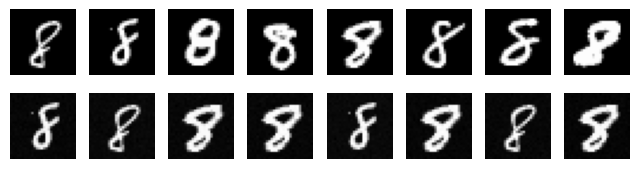

In [9]:
mnist = MNIST(root='../data.nosync/').fit()
X_train, y_train, X_test, y_test = mnist.get_train_and_test_data()

c = 8 # class 8
X_train_8 = X_train[y_train == c].reshape(-1, 28*28)
X_test_8 = X_test[y_test == c].reshape(-1, 28*28)

# create subset of 8 samples
n_samples = 8
X = X_train_8[:n_samples]

q = Memorizer(radius=0.5, n_copying=3).fit(X)
X_gen = q.sample(n_samples)


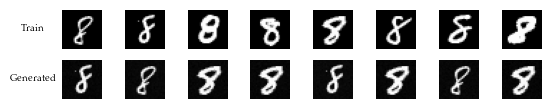

In [17]:
textwidth = set_plotting_params()

fig = plt.figure(figsize=(textwidth, 0.2*textwidth))
grid_spec = fig.add_gridspec(2, 9, width_ratios=[0.3, 1, 1, 1, 1, 1, 1, 1, 1]) # 9 columns first for label

row_labels = ['Train', 'Generated']

for i, row_label in enumerate(row_labels):
    ax = fig.add_subplot(grid_spec[i, 0])
    ax.text(0.5, 0.5, row_label, ha='center', va='center')
    ax.axis('off')

for i in range(8):
    ax = fig.add_subplot(grid_spec[0, i+1])
    ax.imshow(X[i].reshape(28, 28), cmap='gray')
    ax.axis('off')

    ax = fig.add_subplot(grid_spec[1, i+1])
    ax.imshow(X_gen[i].reshape(28, 28), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig('../doc/Presentation/mot_data_copying1.png', dpi=300)

## Meehan et al. (2020)

In [2]:
p = Halfmoons(noise=0.1)

n_train = 2000
n_test = 1000

X = p.sample(n_train)
X_test = p.sample(n_test)
q = Memorizer(radius=0.03, n_copying=1000).fit(X)
X_gen = q.sample(n_test)

X_NN = NearestNeighbors(n_neighbors=1).fit(X)
LXgen, _ = X_NN.kneighbors(X=X_gen, n_neighbors=1)
LXtest, _ = X_NN.kneighbors(X=X_test, n_neighbors=1)

LXgen = LXgen.flatten()
LXtest = LXtest.flatten()

In [3]:
textwidth = set_plotting_params()
colors = sns.color_palette('colorblind')
markers = ['o', 'x', 's', '^', 'v', '<', '>', 'd', 'p', 'P']

n_display = 50
X = p.sample(n_display)
q = Memorizer(radius=0.03, n_copying=int(n_display)).fit(X)
X_gen = q.sample(n_display)
X_test = p.sample(n_display)

fig, axs = plt.subplots(1, 2, figsize=(textwidth, 0.5*textwidth))
axs[0].scatter(*X.T, s=10, label='Train', color=colors[0], marker=markers[0], alpha=0.7)
axs[0].scatter(*X_gen.T, s=10, label='Generated', color=colors[1], marker=markers[1], alpha=0.7)
axs[0].scatter(*X_test.T, s=10, label='Validation', color=colors[2], marker=markers[2], alpha=0.7)
axs[0].legend()
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].hist(LXtest, bins=50, alpha=0.5, color=colors[2], label='Validation', density=True)
axs[1].hist(LXgen, bins=15, alpha=0.5, color=colors[1], label='Generated', density=True)
axs[1].legend()
axs[1].set_xlabel('Distance to nearest neighbor in the training set')
axs[1].set_ylabel('Density')
axs[1].set_xlim([0, 0.15])
axs[1].set_xticks([0, 0.05, 0.1, 0.15])

plt.tight_layout()
plt.savefig('../doc/Presentation/vis_meehan.png', dpi=300)
plt.close()

In [33]:
# counter example: Visualization Mixed Model 
q_copy = Memorizer(radius=0.05, n_copying=3).fit(X)
q_underfit = Memorizer(radius=0.3, n_copying=len(X)).fit(X)
q = Mixture(rho=0.4, q1=q_copy, q2=q_underfit)

X_gen = q.sample(n_samples*2)

textwidth = set_plotting_params()
colors = sns.color_palette('colorblind')
markers = ['o', 'x', 's', '^', 'v', '<', '>', 'd', 'p', 'P']

fig, ax = plt.subplots(1, 1, figsize=(0.5*textwidth, 0.4*textwidth))
ax.scatter(*X_gen.T, s=10, label='Generated', color=colors[1], marker=markers[1], alpha=0.7)
ax.scatter(*X.T, s=10, label='Train', color=colors[0], marker=markers[0], alpha=0.7)
# ax.scatter(*X_test.T, s=10, label='Test', color=colors[2], marker=markers[2], alpha=0.7)
ax.legend()
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('$q = \\rho * q_{copy} + (1-\\rho) * q_{underfit}$')
plt.tight_layout()
plt.savefig('../doc/Presentation/Vis_Mixed_Model.png', dpi=300)
plt.close()

## Bhattacharjee et al. (2023)

In [6]:
### plotting
textwidth = set_plotting_params()
line_styles = ['--', '-.', ':']
colors = sns.color_palette('colorblind')
markers = ['.', 'x', '^', 'h', '^', 'v', '>', '<', 'p', '*', 'h']
markersize = [5, 4, 3, 2, 1]

C_S_hf = np.load('../doc/Limitations/C_S_hf.npy')
C_S_mnist = np.load('../doc/Limitations/C_S_mnist.npy')
rhos = np.round(np.linspace(0, 1, 11), 2)
num_regions_mnist = [25, 50, 75]
num_regions_hf = [5, 10, 20]

fig, axs = plt.subplots(1, 2, figsize=(textwidth, 2))

axs_results = [axs[0], axs[1]]
for i, (C_S, ax, num_regions) in enumerate(zip([C_S_hf, C_S_mnist], axs_results, [num_regions_hf, num_regions_mnist])):
    mean = np.mean(C_S[:, 0, :], axis=1)
    std = np.std(C_S[:, 0, :], axis=1)
    ax.plot(rhos, mean,
            linestyle=line_styles[0],
            color=colors[3],
            marker=markers[0],
            markersize=markersize[0],
    )
    ax.fill_between(rhos, mean - std, mean + std, alpha=0.2, color=colors[3])

    ax.axhline(-3, color='black', linestyle='-')
    ax.set_xlabel("$\\rho$")
    ax.set_ylabel("$C_S$")
    ax.set_title("(a) Halfmoons (2D)" if i == 0 else "(b) MNIST (64D)")
    ax.set_xticks(np.linspace(0, 1, 6))

plt.tight_layout()
plt.savefig('../doc/Presentation/Fail_Meehan.png', dpi=300)
plt.close()

# Our Algorithm using Random Projections

In [39]:
colors = sns.color_palette('colorblind')

# Define transformations for MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='../data.nosync/', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='../data.nosync/', train=False, download=True, transform=transform)

# Filter for class 8 samples
train_samples_indices = [i for i in range(len(train_dataset)) if train_dataset.targets[i] == 8]
test_samples_indices = [i for i in range(len(test_dataset)) if test_dataset.targets[i] == 8]

# Function to add a colored border to images
def add_border(img, color, border_size=5):
    # Convert to PIL Image in grayscale
    img = img.squeeze(0)  # Remove the channel dimension (1,)
    img = Image.fromarray((img.numpy() * 255).astype(np.uint8), mode='L')  # Grayscale

    # Add colored border
    img_with_border = ImageOps.expand(img.convert("RGB"), border=border_size, fill=color)  # Convert to RGB after expanding
    return img_with_border

# Select 10 random samples from training and test sets for class 8
num_samples = 40
train_samples_idx = random.sample(train_samples_indices, num_samples)
test_samples_idx = random.sample(test_samples_indices, num_samples)

# Prepare train and test samples with colored borders
set1_images = [add_border(train_dataset[i][0], 'blue', border_size=5) for i in train_samples_idx]
set2_images = [add_border(test_dataset[i][0], 'orange', border_size=5) for i in test_samples_idx]

# Generate random positions for the images
def generate_random_positions(num_images, canvas_size):
    positions = []
    img_width, img_height = 28 + 10, 28 + 10  # MNIST image size (28x28) + border size
    for _ in range(num_images):
        x = random.randint(0, canvas_size[0] - img_width)
        y = random.randint(0, canvas_size[1] - img_height)
        positions.append((x, y))
    return positions

# Set canvas size
canvas_size = (200, 400)

# Get random positions for both sets
positions_set1 = generate_random_positions(len(set1_images), canvas_size)
positions_set2 = generate_random_positions(len(set2_images), canvas_size)

# Create a blank canvas
canvas = Image.new('RGB', canvas_size, (255, 255, 255))  # 'RGB' mode for colored borders

# Paste Set 1 images (training set) at random positions
for img, pos in zip(set1_images, positions_set1):
    canvas.paste(img, pos)

# Paste Set 2 images (test set) at random positions
for img, pos in zip(set2_images, positions_set2):
    canvas.paste(img, pos)

# Convert the canvas to an array for displaying
canvas_array = np.array(canvas)

# Plot the final result
plt.figure(figsize=(6, 10))
plt.imshow(canvas_array)
plt.axis('off')
plt.savefig('../doc/Presentation/vis_high_dim_space_vertical.png', dpi=300)
plt.close()